In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import tqdm
from tqdm import tqdm

In [2]:
test = pd.read_csv('../input/signate-stcup2020-new/test.csv')
train = pd.read_csv('../input/signate-stcup-2020/train.csv')

In [3]:
def proba_to_prediction(proba_df):
    ids = proba_df.ids
    prediction_df = proba_df.drop(["ids"],axis=1)
    
    # predict "jobflag" by proba
    prediction_df["jobflag"] = prediction_df.idxmax(axis=1)
    prediction_df["id"] = ids.astype(int)
    # 
    prediction_df = prediction_df.drop(["1","2","3","4"],axis=1)
    prediction_df = prediction_df[["id","jobflag"]]
    return prediction_df

In [4]:
#define make_prediction function
def make_prediction(probas_list):
    #prediction_df = pd.DataFrame([])
    proba_df = pd.DataFrame({'1': [], '2': [], '3':[], '4':[], "ids": []})
    ensenbled_PATH = ""
    ids = []
    sum_weight = 0
    
    for n, (proba, weight) in enumerate(probas_list):
        # prepare to save and ensemble
        try:
            save_PATH = proba.split("/")[-1].split("_")[1]
            ensenbled_PATH += save_PATH+"_"
            proba = pd.read_csv(proba)
        except:
            pass
        
        if n == 0:
            ids = proba["ids"].astype(int)
            proba_df = proba*weight
        else:
            #ensenble
            proba_df += proba * weight
            
        sum_weight += weight
    proba_df /= sum_weight
    
    prediction_df = proba_df.drop(["ids"],axis=1)
    # predict "jobflag" by proba
    prediction_df["jobflag"] = prediction_df.idxmax(axis=1)
    prediction_df["id"] = ids.astype(int)
    prediction_df = prediction_df.drop(["1","2","3","4"],axis=1)
    prediction_df = prediction_df[["id","jobflag"]]
    
    # save
    #prediction_df.to_csv(ensenbled_PATH+".csv", index=False, header=False)
    return prediction_df, proba_df

In [5]:
def proba_to_pseudo(probas_df, threshold):
    prediction_df = proba_to_prediction(probas_df)
    pseudo_index = np.where(probas_df.drop(["ids"],axis=1)>threshold)[0]
    pseudo_df = prediction_df.reindex(index=pseudo_index)
    pseudo_df["description"] = test.reindex(index=pseudo_index)["description"]
    pseudo_df = pseudo_df.loc[:, ['id', 'description', 'jobflag']]
    pseudo_df = pseudo_df.drop_duplicates()
    return pseudo_df

def proba_from_normalized_proba(df):
    new_df = pd.DataFrame([])
    for ids in tqdm(np.arange(2931, 4674, 1)):
        n_df = df[df.ids==ids].sum(axis=0)/len(df[df.ids==ids])
        new_df = pd.concat([new_df, n_df], axis=1)
    new_df = new_df.T
    new_df = new_df.reset_index(drop=True)
    return new_df

In [6]:
probas_list1 = [
    ('../input/version40s/_ELECTRA_v40_0_ELECTRA_v40_1_ELECTRA_v40_2_ensemble.csv', 1),
    ('../input/version40s/_ROBERTA_v40_0_ROBERTA_v40_1_ROBERTA_v40_2_BERT_v40_0_BERT_v40_1_BERT_v40_2_ensemble.csv', 1)
]
prediction_df, probas_df = make_prediction(probas_list1)
prediction_df.to_csv("4_BRE_XA_final_sub.csv", index=False, header=False)

In [7]:
threshold1 = 0.98
pseudo_df = proba_to_pseudo(probas_df, threshold1)
pseudo_df.to_csv(f"4_BRE_XA{threshold1*100}%_pseudo.csv", index=False)
pseudo_df#.description.loc[1712]

,id,description,jobflag
3,2934,"Apply your expertise in quantitative analysis,...",1
15,2946,Performs special assignments or assigns projec...,4
36,2967,"Provide regular, clear, and consistent communi...",4
45,2976,Screen incoming applications for a match with ...,4
49,2980,Update account status records and collection e...,4
...,...,...,...
1712,4643,"Processing, cleansing, and verifying the integ...",1
1714,4645,Evaluate performance results and recommends ma...,4
1727,4658,Create original insights from data by executin...,1
1732,4663,Work with street leading analysts to facilitat...,1


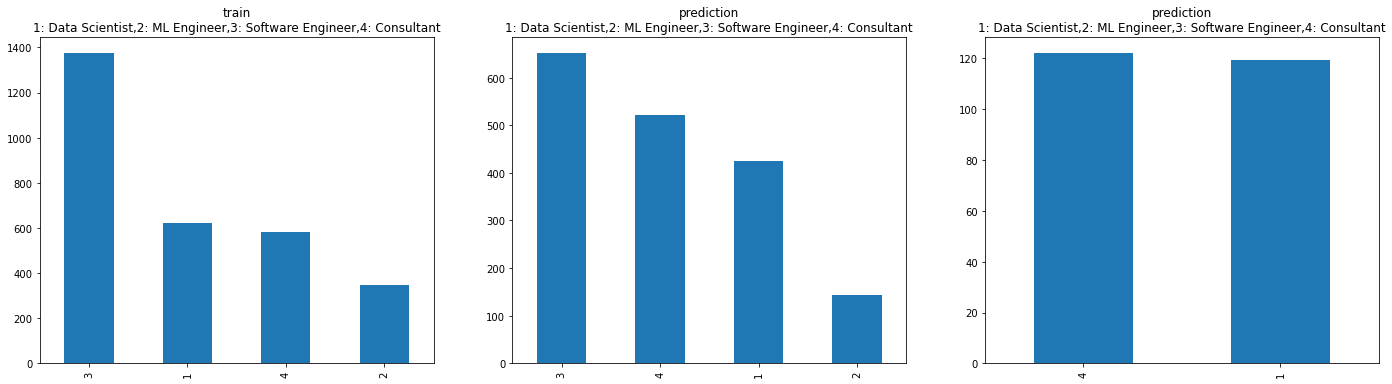

In [8]:
#visualize the data
plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
plt.title("train\n1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
train.jobflag.value_counts().plot(kind="bar")

plt.subplot(1,3,2)
plt.title("prediction\n1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
prediction_df.jobflag.value_counts().plot(kind="bar")

plt.subplot(1,3,3)
plt.title("prediction\n1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
pseudo_df.jobflag.value_counts().plot(kind="bar")

job_dict_init = {1:"DS",2:"MLEng",3:"SE",4:"Consul"}
confusion_matrix = confusion_matrix(pred_1["3"], pred_2["3"])
CMD = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=job_dict_init.values() )
CMD.plot()